## Part 1: Data preparation

In this notebook, we will learn how to extract different kind of object models from images, and how to prepare them for subsequent shape analysis.

In [1]:
import os
import numpy as np
import imageio
import h5py
import matplotlib.pyplot as plt
import copy
from spline_models.spline_curve_model import B3_spline_curve

In [2]:
plt.rcParams['figure.dpi'] = 200

### 0. Contour extraction

In the exercises, we will be using two image sets:

- A dataset of brightfield microscopy images of a C. elegans live/dead assay from https://bbbc.broadinstitute.org/BBBC010

/var/folders/gc/9kwtxlj918l6ht3n4bqx1yy40000gn/T/ipykernel_41441/39687663.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  live_worms = imageio.imread('data/C. elegans/1649_1109_0003_Amp5-1_B_20070424_B07_w2_F3BB43AA-D215-44C1-B2FD-A89741699E5F.tif')
/var/folders/gc/9kwtxlj918l6ht3n4bqx1yy40000gn/T/ipykernel_41441/39687663.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  dead_worms = imageio.imread('data/C. elegans/1649_1109_0003_Amp5-1_B_20070424_A23_w2_71C5704E-F745-4D29-B3B2-51216C02A45D.tif')


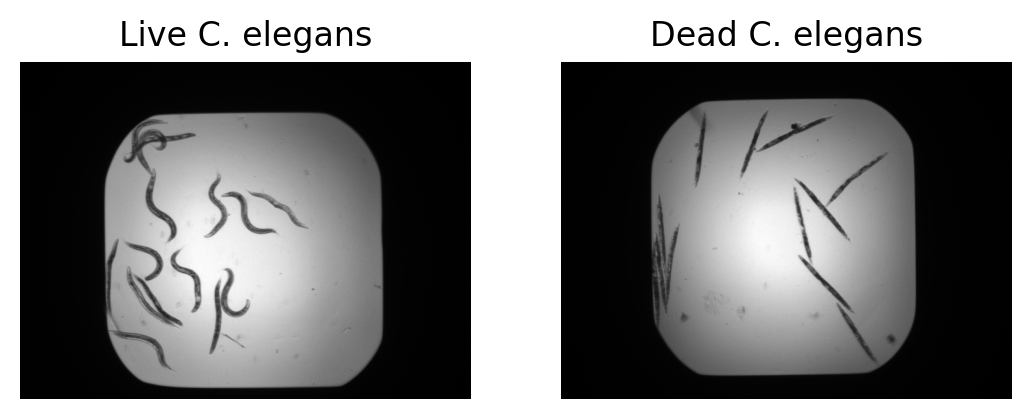

In [3]:
# Visualize a sample of the data by running the lines below
live_worms = imageio.imread('data/C. elegans/1649_1109_0003_Amp5-1_B_20070424_B07_w2_F3BB43AA-D215-44C1-B2FD-A89741699E5F.tif')
dead_worms = imageio.imread('data/C. elegans/1649_1109_0003_Amp5-1_B_20070424_A23_w2_71C5704E-F745-4D29-B3B2-51216C02A45D.tif')

fig, ax = plt.subplots(1, 2)
ax[0].imshow(live_worms, cmap='gray')
ax[0].axis('off')
ax[0].set_title('Live C. elegans')

ax[1].imshow(dead_worms, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Dead C. elegans')

plt.show()

- A dataset of fluorescence microscopy images of wild-type (LMNA++) and lamin-deficient (LMNA--) mouse embryonic fibroblasts (MEF) from https://github.com/kukionfr/Micropattern_MEF_LMNA_Image

/var/folders/gc/9kwtxlj918l6ht3n4bqx1yy40000gn/T/ipykernel_41441/2154242104.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  wt_cell = imageio.imread('data/MEF_LMNA/wildtype/raw_images/xy001c1.tif')
/var/folders/gc/9kwtxlj918l6ht3n4bqx1yy40000gn/T/ipykernel_41441/2154242104.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  wt_nuc = imageio.imread('data/MEF_LMNA/wildtype/raw_images/xy001c2.tif')
/var/folders/gc/9kwtxlj918l6ht3n4bqx1yy40000gn/T/ipykernel_41441/2154242104.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.

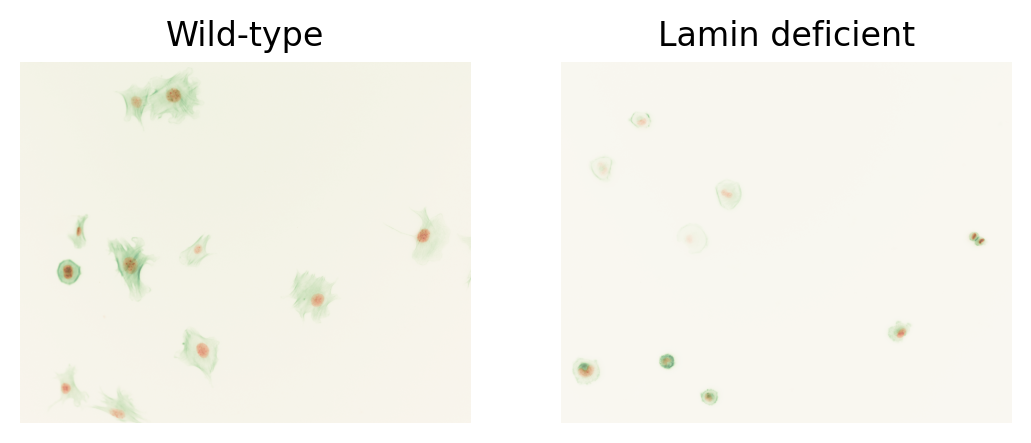

In [4]:
# Visualize a sample of the data by running the lines below
wt_cell = imageio.imread('data/MEF_LMNA/wildtype/raw_images/xy001c1.tif')
wt_nuc = imageio.imread('data/MEF_LMNA/wildtype/raw_images/xy001c2.tif')
lmna_cell = imageio.imread('data/MEF_LMNA/lmna_deficient/raw_images/xy001c1.tif')
lmna_nuc = imageio.imread('data/MEF_LMNA/lmna_deficient/raw_images/xy001c2.tif')

fig, ax = plt.subplots(1, 2)
ax[0].imshow(wt_cell, cmap='Greens')
ax[0].imshow(wt_nuc, cmap='Reds', alpha=0.5)
ax[0].axis('off')
ax[0].set_title('Wild-type')

ax[1].imshow(lmna_cell, cmap='Greens')
ax[1].imshow(lmna_nuc, cmap='Reds', alpha=0.5)
ax[1].axis('off')
ax[1].set_title('Lamin deficient')

plt.show()

**0.1** Load a sample segmentation masks for each datasets with the lines below. 

Notice that the segmentation masks are provided in two different format that are commonly encountered when dealing with microscopy image sets: binary png images or hdf5 file. Which format do you find the most convenient? Why?

In [5]:
# C. elegans dataset
filename_png = 'data/C. elegans/B07_06_ground_truth.png'
celegans_mask=imageio.imread(filename_png)

/var/folders/gc/9kwtxlj918l6ht3n4bqx1yy40000gn/T/ipykernel_41441/3262953144.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  celegans_mask=imageio.imread(filename_png)


In [6]:
# MEF dataset
filename_h5 = 'data/MEF_LMNA/xy001c1_instances.h5'
with h5py.File(filename_h5, 'r') as h5file:
    mef_mask = h5file['exported_data'][:, :, 0]

**0.2** Visualize the masks from each collection with the lines below. Which immediate difference do you notice between the two segmentation masks? 

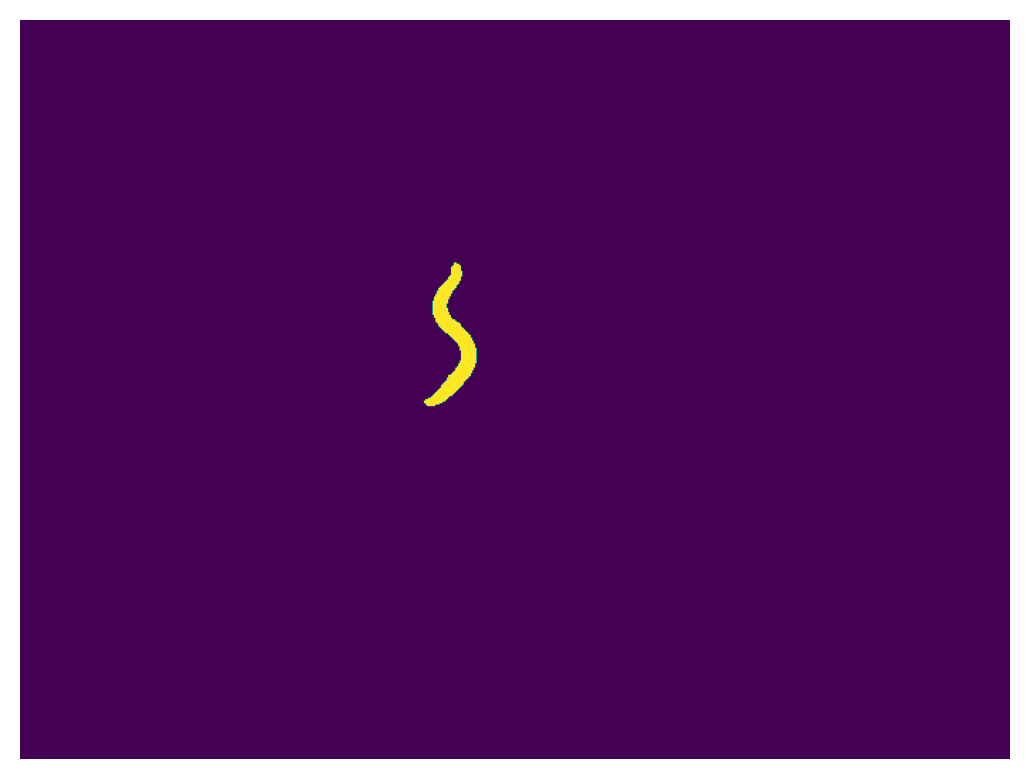

In [7]:
# C. elegans dataset
plt.imshow(celegans_mask)
plt.axis('off')
plt.show()

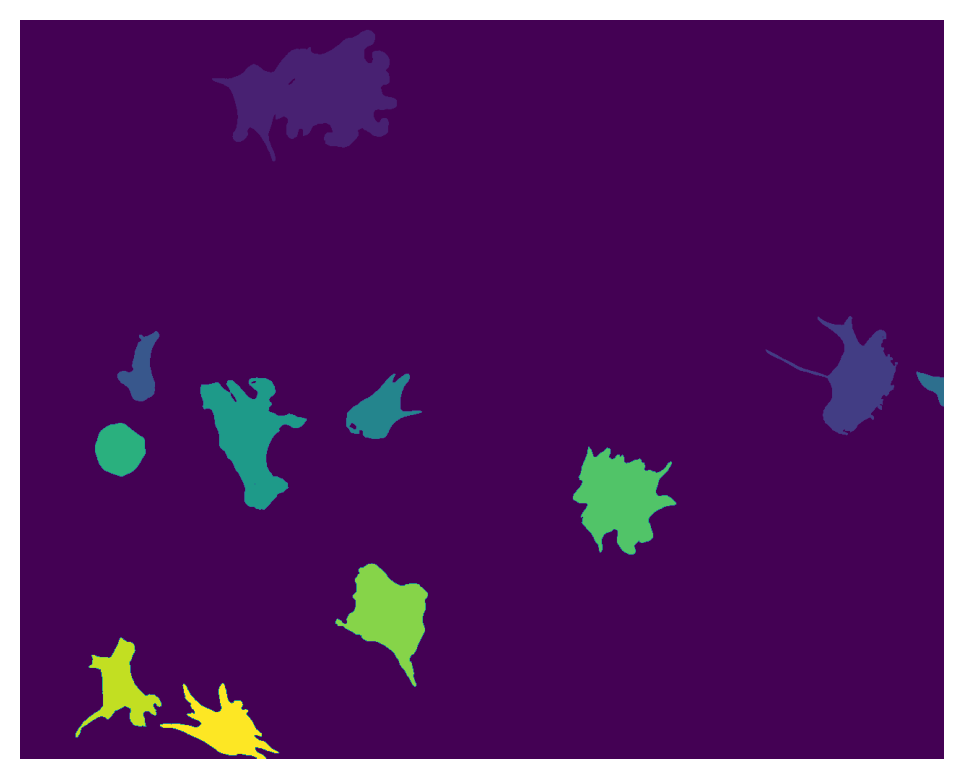

In [8]:
# MEF dataset
plt.imshow(mef_mask)
plt.axis('off')
plt.show()

**0.3 [FOR MLF ONLY]**: retreive the set of contour points of each individual objects in the `mef_mask` image.

*Hint: use the `measure.find_contours` function from the `skimage` library. Make sure you read the documentation and understand the inputs that this function needs!*

In [9]:
from skimage.measure import find_contours

In [12]:
# Desired output: mef_contours array containing the contour points of each object in mef_mask
# Add your code here!
mef_contours =

**0.4 [FOR MLF ONLY]** Run the lines below to visualize the result.

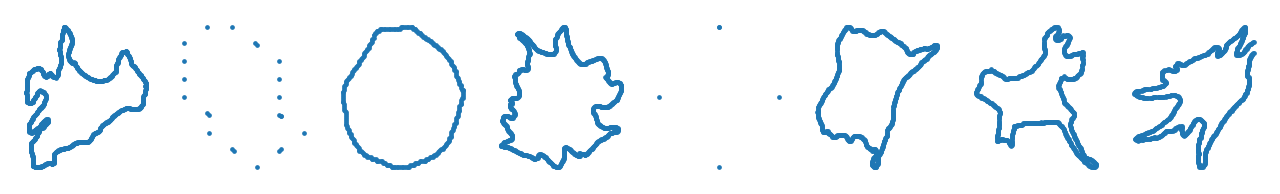

In [13]:
# Visualize the result 
fig, ax = plt.subplots(1,len(mef_contours),figsize=(len(mef_contours),1))
for i, obj in enumerate(mef_contours):
    ax[i].scatter(obj[:,0],obj[:,1],s=.5)
    ax[i].axis('off')

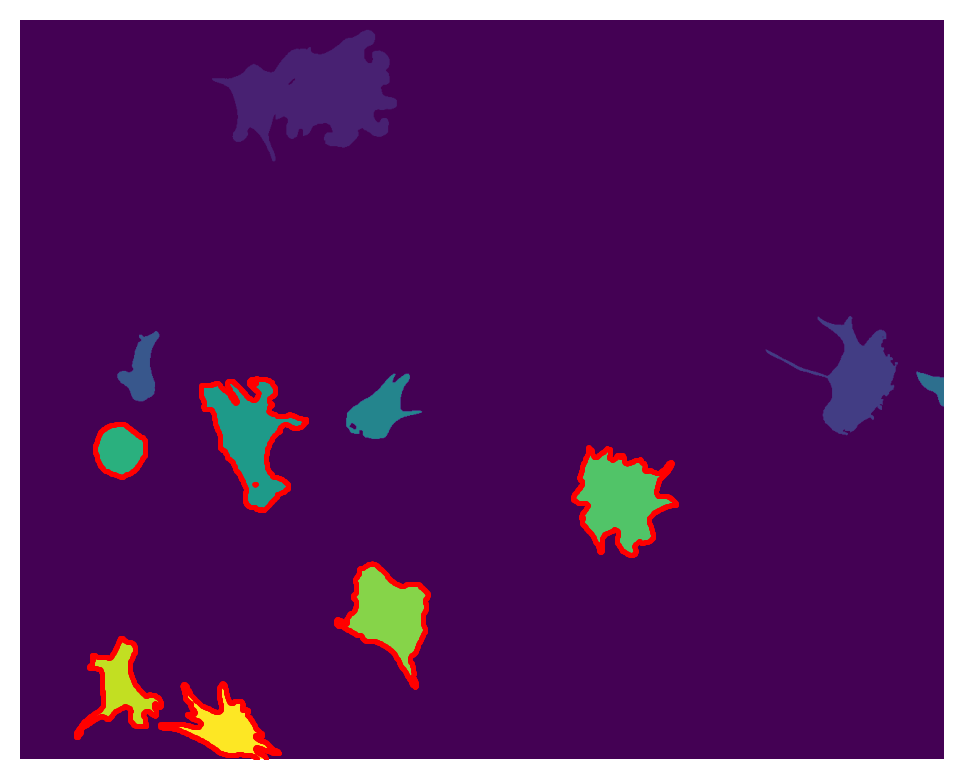

In [14]:
# Visualize the result on top of the mask data
plt.imshow(mef_mask)
for i, obj in enumerate(mef_contours):
    plt.scatter(obj[:,1],obj[:,0],s=.5,c='red')
plt.axis('off')
plt.show()

**0.3 [FOR C. elegans ONLY]**: retreive the midline of the worm in `celegans_mask`. In image processing, the midline axis is called "skeleton" (https://en.wikipedia.org/wiki/Morphological_skeleton).

*Hint: use the `skeletonize` function provided below.*

In [15]:
from skimage.morphology import skeletonize_3d
from skimage.measure import label

In [16]:
def sort_by_distance(source, points):
    sorted_points=[]
    
    current=source
    # While there are still points in the initial list
    while len(points)>0:
        # Get the list of distances to the current point
        dist=[np.linalg.norm(current-p) for p in points]
        # Get the point with the smallest distance to the current point
        ind_next=np.argmin(dist)
        current=copy.deepcopy(points[ind_next])
        # Add it at the end to the sorted_points list
        sorted_points+=[current]
        # Remove it from the intial list of points
        points=np.delete(points,ind_next,axis=0)
    
    return np.array(sorted_points)

In [17]:
# extracts the morphological skeleton of the object
def skeletonize(img):
    # Obtain the skeleton
    skeletonized=skeletonize_3d(img)
    # Get a list of the points on the skeleton
    points=np.transpose(np.where(skeletonized>0))

    # for each point on the skeleton
    for x, y in points:
        # Isolate the square around the points on the initial image
        square=copy.deepcopy(skeletonized[np.max((0,x-1)):np.min((x+2,skeletonized.shape[0])),
                                          np.max((0,y-1)):np.min((y+2,skeletonized.shape[1]))])
        
        # mark the current point as background
        square[1,1]=0
        
        source=[]
        # Label the square
        # if we are in the middle of a line, we have just split it by marking the point as
        # background, therefore we will have 2 different labels (each end of the line). 
        # Otherwise, if we have a single label, we are exactly at the end of a line 
        # so we mark this point as the source and exist the loop. 
        if np.max(label(square))==1:
            source=[x,y]
            break
        # in case we did not find anything we default the source to the first point. 
        if len(source)<1:
            source=points[0]
    
    return sort_by_distance(source, points)

In [18]:
# Desired output: celegans_contour array containing the contour points of the object in celegans_mask
# Add your code here!
celegans_contour = skeletonize(celegans_mask)

**0.4 [FOR C. elegans ONLY]** Run the lines below to visualize the result.

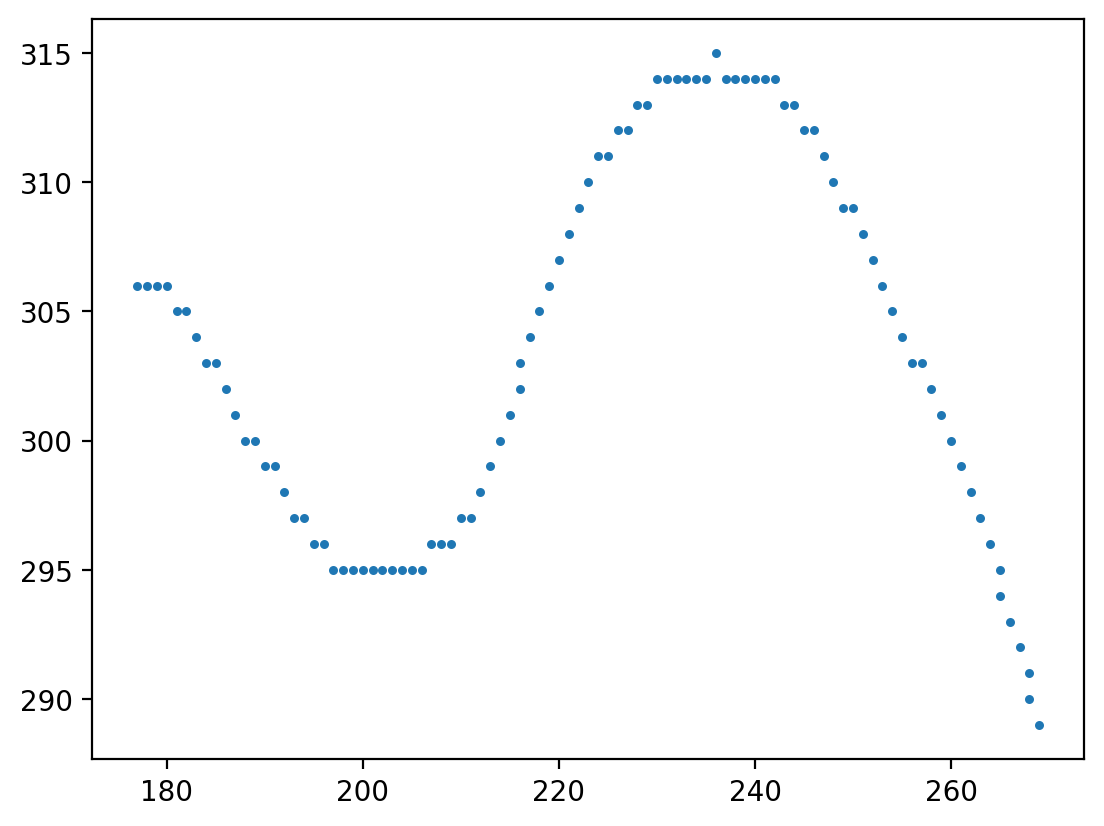

In [19]:
# Visualize the result on top of the mask data
plt.scatter(celegans_contour[:,0],celegans_contour[:,1],s=5)
plt.show()

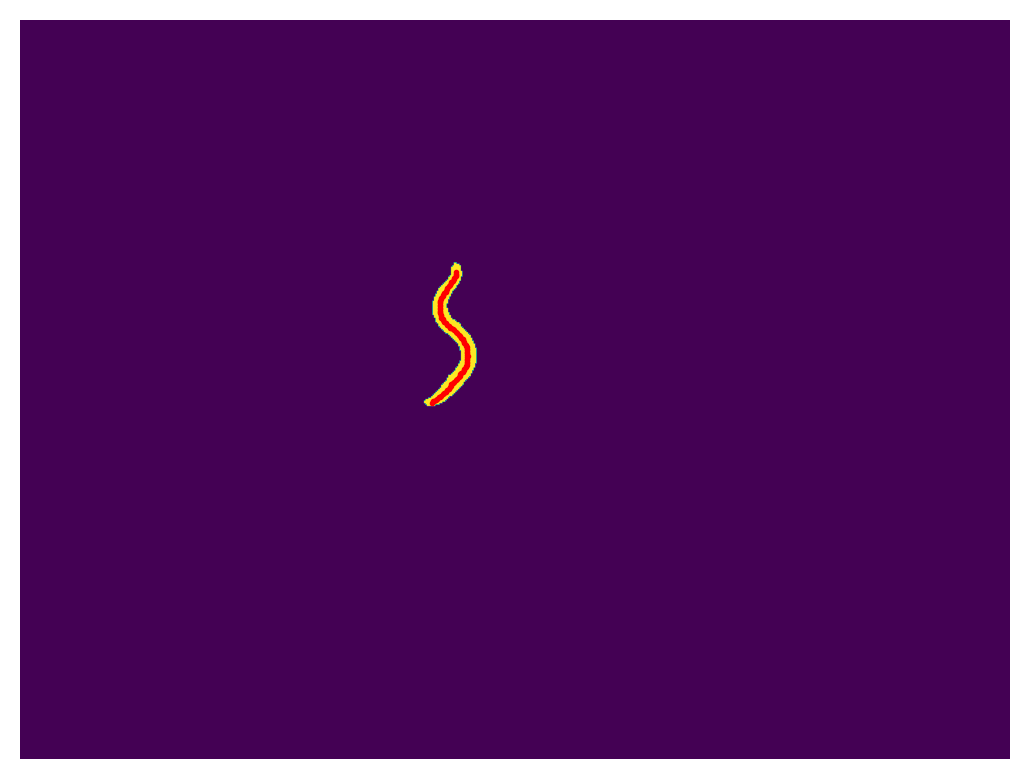

In [20]:
# Visualize the result on top of the mask data
plt.imshow(celegans_mask)
plt.scatter(celegans_contour[:,1],celegans_contour[:,0],s=1,c='red')
plt.axis('off')
plt.show()

### 1. Discrete (point-based) model

**1.1** Pick one of the objects from either of the datasets and extract a set of N equidistant points on it. How small can N be in order for the point-based model to accurately capture the shape of the object? How does it compare to the amount of points the contour was initially composed of?

In [ ]:
# Choose an integer value for N
N=

# Choose whether you want to work with the MEF or C. elegans dataset
# MEF
#obj=mef_contours[0]
#mask_img=mef_mask

# C. elegans
#obj=celegans_contour
#mask_img=celegans_mask

In [ ]:
# Desired output: point_model array containing N equidistant points on the object contour
# Add your code here!
point_model=

**1.2** Run the lines below to visualize the result.

In [ ]:
# Visualize the result
plt.scatter(point_model[:,0],point_model[:,1],s=10)
plt.show()

In [ ]:
# Visualize the result on top of the mask data
plt.imshow(mask_img)
plt.scatter(point_model[:,1],point_model[:,0],s=1,c='red')
plt.axis('off')
plt.show()

### 2. Continuous (spline-based) model

**2.1** The lines below create a continuous cubic B-spline model from the N points you sampled in 1.1. 

Go back to 1.1 and draw a smaller number of N points from the contour. How small can N be in order for the spline-based model to accurately capture the shape of the object? How does it differ from what you observed in 1.1?

In [ ]:
# Adapt the closed_curve flag depending on whether you chose to work with the C. elegans or MEF data in 1.1
closed_curve=False 
spline_model=B3_spline_curve(N, closed_curve)
spline_model.get_spline_coefficients(point_model)

**2.2** Run the lines below to visualize the result.

In [ ]:
# Since the spline-based model is continuous, one can draw as much points as one wants from it for visualization purpose
spline_model_points=spline_model.sample(1000)

plt.scatter(spline_model_points[:,0],spline_model_points[:,1],s=1)
plt.show()

In [ ]:
plt.imshow(mask_img)
plt.scatter(spline_model_points[:,1],spline_model_points[:,0],s=1,c='red')
plt.axis('off')
plt.show()